## Qa) RL Problem Formulation

1. **State Space (S)**
   - Each state corresponds to a user's profile or context.
   - It includes information about the user's history, preferences, and current situation.

2. **Action Space (A)**
   - The action space consists of movie recommendations.
   - Each action corresponds to recommending a specific movie to the user.

3. **Reward Function (R)**
   - The reward function assigns a reward based on the user's interaction with the recommended movie.
   - Positive reward for a clicked/watched movie, negative reward for an ignored movie.

4. **Model (T)**
   - The transition model describes how the chosen recommendation affects the user's state.
   - It captures the dynamics of user preferences and how they evolve over time.

5. **Policy (π)**
   - The policy maps states (user profiles) to actions (movie recommendations).
   - The objective is to find an optimal policy that maximizes the cumulative reward over time.

## Dataset
- We use the MovieLens dataset, which contains user ratings and movie metadata.
- Features include user IDs, movie IDs, ratings, genres, release years, etc.


In [3]:
import tensorflow as tf
import tf_agents
from tf_agents.bandits.environments import movielens_py_environment
from tf_agents.environments import tf_py_environment
from tf_agents.bandits.environments import environment_utilities
from tf_agents.bandits.metrics import tf_metrics as tf_bandit_metrics
from tf_agents.bandits.agents import lin_ucb_agent
from tf_agents.bandits.agents import linear_thompson_sampling_agent as lin_ts_agent
from tf_agents.networks import q_network
from tf_agents.bandits.agents import neural_epsilon_greedy_agent as eps_greedy_agent
from tf_agents.bandits.agents.examples.v2 import trainer
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.drivers import driver
from tf_agents.drivers import dynamic_step_driver
from tf_agents.policies import random_tf_policy
import functools
import os
import numpy as np
from matplotlib import pyplot as plt

In [4]:
BATCH_SIZE = 8
STEPS_PER_LOOP = 2
RANK_K = 20
NUM_ACTIONS = 20

## Qb) MovieLensPyEnvironment

In [5]:
env = movielens_py_environment.MovieLensPyEnvironment(
    "./sample_data/u.data", RANK_K, BATCH_SIZE, num_movies=NUM_ACTIONS, csv_delimiter="\t"
)
environment = tf_py_environment.TFPyEnvironment(env)

In [6]:
optimal_reward_fn = functools.partial(
    environment_utilities.compute_optimal_reward_with_movielens_environment,
    environment=environment,
)

optimal_action_fn = functools.partial(
    environment_utilities.compute_optimal_action_with_movielens_environment,
    environment=environment,
)

In [7]:
linucb = lin_ucb_agent.LinearUCBAgent(
    time_step_spec=environment.time_step_spec(),
    action_spec=environment.action_spec(),
    tikhonov_weight=0.001,
    alpha=10.0,
    dtype=tf.float32,
    accepts_per_arm_features=False,
)

In [8]:
lints = lin_ts_agent.LinearThompsonSamplingAgent(
    time_step_spec=environment.time_step_spec(),
    action_spec=environment.action_spec(),
    dtype=tf.float32,
    accepts_per_arm_features=False,
)

In [9]:
EPSILON = 0.05

network = q_network.QNetwork(
    input_tensor_spec=environment.time_step_spec().observation,
    action_spec=environment.action_spec(),
    fc_layer_params=(50, 50, 50),
)

neureps = eps_greedy_agent.NeuralEpsilonGreedyAgent(
    time_step_spec=environment.time_step_spec(),
    action_spec=environment.action_spec(),
    reward_network=network,
    optimizer=tf.compat.v1.train.AdamOptimizer(learning_rate=0.005),
    epsilon=EPSILON,
    emit_policy_info="predicted_rewards_mean",
    info_fields_to_inherit_from_greedy=["predicted_rewards_mean"],
)

## Qc) Regret metric

In [10]:
regret_metric = tf_bandit_metrics.RegretMetric(optimal_reward_fn)
suboptimal_arms_metric = tf_bandit_metrics.SuboptimalArmsMetric(optimal_action_fn)

## Qd) Train and plot regret for 500 timesteps (20000 takes too long)

In [14]:
def train(agent):
    if agent == "LinUCB":
        agent = linucb
    elif agent == "LinTS":
        agent = lints
    elif agent == "NeurEps":
        agent = neureps

    replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
        data_spec=agent.policy.trajectory_spec,
        batch_size=BATCH_SIZE,
        max_length=STEPS_PER_LOOP,
    )

    observers = [replay_buffer.add_batch, regret_metric]

    driver = dynamic_step_driver.DynamicStepDriver(
        env=environment,
        policy=agent.collect_policy,
        num_steps=STEPS_PER_LOOP * BATCH_SIZE,
        observers=observers,
    )

    regret_values = []

    for _ in range(500):
        driver.run()
        loss_info = agent.train(replay_buffer.gather_all())
        replay_buffer.clear()
        regret_values.append(regret_metric.result())

    return regret_values, agent

Text(0, 0.5, 'Average Regret')

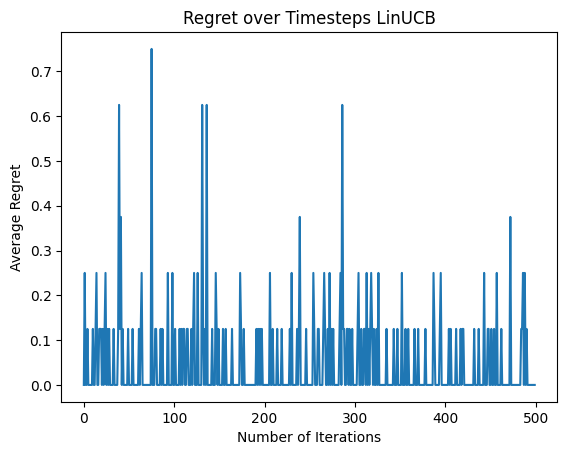

In [15]:
regret_values_linucb, linucb_agent = train("LinUCB")
plt.plot(regret_values_linucb)
plt.title("Regret over Timesteps LinUCB")
plt.xlabel("Number of Iterations")
plt.ylabel("Average Regret")

In [23]:
int(sum(regret_values_linucb))

23

Text(0, 0.5, 'Average Regret')

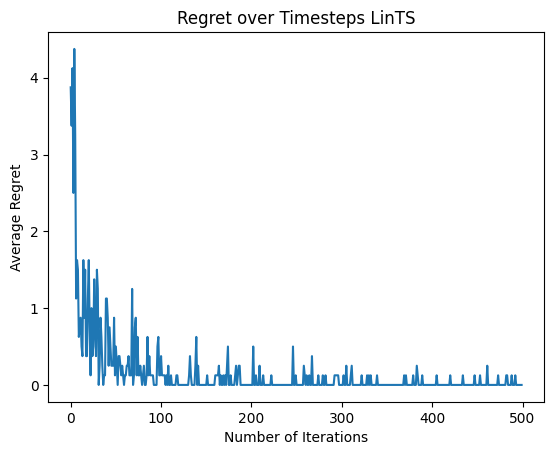

In [17]:
regret_values_lints, lints_agent = train("LinTS")
plt.plot(regret_values_lints)
plt.title("Regret over Timesteps LinTS")
plt.xlabel("Number of Iterations")
plt.ylabel("Average Regret")

In [24]:
int(sum(regret_values_lints))

78

Text(0, 0.5, 'Average Regret')

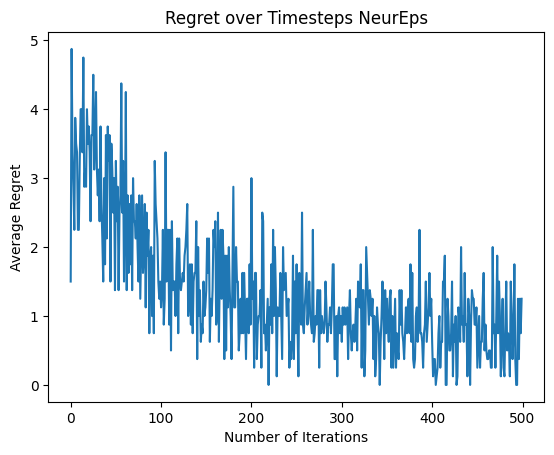

In [19]:
regret_values_neureps, neureps_agent = train("NeurEps")
plt.plot(regret_values_neureps)
plt.title("Regret over Timesteps NeurEps")
plt.xlabel("Number of Iterations")
plt.ylabel("Average Regret")

In [25]:
int(sum(regret_values_neureps))

686

From the above observations, we can conclude that the regret reduces quickly and stays low in **LinUCB** and hence, it is most likely the best agent for the movie recommendation

## Qe) Policy to recommend movies

In [29]:
def recommend_movies(agent, observation):
    time_step = tf_agents.trajectories.time_step.TimeStep(
        step_type=tf.constant([[2]], dtype=tf.int32),
        reward=tf.constant([[0.0]], dtype=tf.float32),
        discount=tf.constant([[1.0]], dtype=tf.float32),
        observation=observation,
    )

    action_step = agent.policy.action(time_step)
    return action_step.action.numpy()[0]

In [30]:
observation = np.array([1, 25, 35, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1])
observation = np.expand_dims(observation, axis=0)
recommend_movies(lints_agent, observation=observation)

13